In [1]:
from matplotlib import pyplot as plt
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from conf import settings
from utils import get_network, get_test_dataloader
from models.resnet import resnet18

In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.decomposition import PCA
import numpy as np

In [4]:
baseline_missed = set(np.loadtxt('baseline_wrong.txt'))
approach3_missed = set(np.loadtxt('approach3_wrong.txt'))
print('baseline missed: {} | approach 3 missed: {}'.format(len(baseline_missed), len(approach3_missed)))

baseline missed: 2396 | approach 3 missed: 2305


In [5]:
len(baseline_missed - approach3_missed)

685

In [6]:
len(approach3_missed - baseline_missed)

594

In [7]:
len(approach3_missed.intersection(baseline_missed))

1711

In [8]:
approach3_desired = baseline_missed - approach3_missed

In [71]:
id2label = {}
with open('/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python/id2label.txt', 'r') as handle:
    for idx, line in enumerate(handle):
        if idx % 2 == 0:
            element, label = line.strip().split(': ')
            id2label[int(element)] = label

In [72]:
len(id2label)

100

In [11]:
net = resnet18(
            variant_name='3', pos_emb_dim=10,
            softmax_temp=1, variant_loc=3,
            stochastic_stride=False, stride=1
        )

In [12]:
cifar100_test_loader = get_test_dataloader(
    settings.CIFAR100_TRAIN_MEAN,
    settings.CIFAR100_TRAIN_STD,
    #settings.CIFAR100_PATH,
    num_workers=6,
    batch_size=1,
    shuffle=False
    )

Files already downloaded and verified


In [13]:
path = '/coc/pskynet4/gstoica3/checkpoints/resnet18/CSAM_Approach3_BN_PosEmb10_AfterConv3_Temp1/Tuesday_01_February_2022_13h_50m_55s/resnet18-181-best.pth'
weights = torch.load(path)
net_params = {i[0]:i[1] for i in net.named_parameters()}

In [14]:
net.load_state_dict(weights)

<All keys matched successfully>

In [15]:
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [16]:
net = net.cuda()

In [17]:
desired_images = []
desired_labels = []
wrong_images = []
wrong_labels = []
desired_flag = False
wrong_flag = False
desired_data = 64
for n_iter, (image, label) in tqdm(enumerate(cifar100_test_loader)):
    image = image.cuda()
    if n_iter in approach3_desired and not desired_flag:
        desired_images.append(image)
        desired_labels.append(label)
    if n_iter in approach3_missed and not wrong_flag:
        wrong_images.append(image)
        wrong_labels.append(label)
    if len(desired_images) >= desired_data:
        desired_flag = True
    if len(wrong_images) >= desired_data:
        wrong_flag = True
    if desired_flag and wrong_flag: break

985it [00:00, 1392.75it/s]


In [18]:
desired_images = torch.cat(desired_images)
desired_labels = torch.cat(desired_labels)
wrong_images = torch.cat(wrong_images)
wrong_labels = torch.cat(wrong_labels)

In [19]:
predictions = net(wrong_images)

In [20]:
predictions = predictions.argmax(-1).detach().cpu().numpy()

In [21]:
output = wrong_images
for layer in tqdm(net.network_layers[:net.variant_loc]):
    output = layer(output)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1677.05it/s]


In [22]:
output.shape

torch.Size([64, 128, 16, 16])

In [23]:
csam = net.network_layers[net.variant_loc]
batch = csam.input_padder(output)                                        # Pad batch for resolution reduction/preservation
batch = batch.permute(0, 2, 3, 1)
batch_pos = csam.maybe_add_positional_encodings(batch)
X_l, X_g = csam.split_input(batch_pos)

X_g_vectors = csam.global_transform(X_g)                                # [F,B,HW-K^2,C]

raw_compatibilities = csam.cosine_similarity(
X_g, X_l                                                                # [F,B,HW-K^2,C], [F,B,K^2,C]
)                                                                       # [F,B,HW-K^2,K^2]
compatabilities = F.softmax(csam.appraoch_args['softmax_temp'] * raw_compatibilities, dim=2)

W_g = torch.einsum('FBGE,FBGL->FBLE', X_g_vectors, compatabilities)     # [F,B,K^2,C]
X_l = X_l[:, :, :, :csam.spatial_C]                                     # [F,B,K^2,E] -> [F,B,K^2,C]
forget_gate = torch.sigmoid(torch.sum(W_g * X_l, dim=-1)).unsqueeze(-1) # [F,B,K^2,1]

convolved_X = (forget_gate * X_l).sum(dim=2).permute(1,0,2)             # [F,B,K^2,1] x [F,B,K^2,C] -> [F,B,K^2,C] -> [F,B,C] -> [B,F,C]
convolved_X = convolved_X.reshape(
-1, csam.convs_height, csam.convs_width, csam.spatial_C
)                                                                       # [B,F,C] -> [B,F_H,F_W,C]

In [24]:
forget_gate = forget_gate.reshape(196, 64, 9).permute(1, 0, 2)

In [25]:
forget_gate.shape

torch.Size([64, 196, 9])

In [26]:
forget_gate_np = forget_gate.detach().cpu().numpy()

In [27]:
forget_cos = csam.cosine_similarity(forget_gate.unsqueeze(0), forget_gate.unsqueeze(0)).squeeze(0)

# Visualization Script

In [80]:
idx = 63

In [81]:
batch_pca = PCA(n_components=3)
csam_pca = PCA(n_components=3)
filter_pca = PCA(n_components=3)
batch_pca.fit(batch[idx].reshape(-1, 128).detach().cpu().numpy())
csam_pca.fit(convolved_X[idx].reshape(-1, 128).detach().cpu().numpy())
filter_pca.fit(forget_gate_np[idx])
print('Batch Explained Variance: {}'.format(batch_pca.explained_variance_ratio_))
print('Filter Explained Variance: {}'.format(filter_pca.explained_variance_ratio_))
print('CSAM Explained Variance: {}'.format(csam_pca.explained_variance_ratio_))

Batch Explained Variance: [0.2742081  0.07194357 0.05695605]
Filter Explained Variance: [0.51360106 0.15026243 0.12329441]
CSAM Explained Variance: [0.27315578 0.11444124 0.09463593]


In [82]:
print('Explained Variance\t Explained Variance\t Explained Variance')
for var1, var2, var3 in zip(
    batch_pca.explained_variance_ratio_,
    filter_pca.explained_variance_ratio_,
    csam_pca.explained_variance_ratio_
):
    print('{}\t {}\t {}'.format(var1, var2, var3))
# print('Explained Variance')
# for var in filter_pca.explained_variance_ratio_:
#     print(var)
# print('Explained Variance')
# for var in csam_pca.explained_variance_ratio_:
#     print(var)


Explained Variance	 Explained Variance	 Explained Variance
0.27420809864997864	 0.5136010646820068	 0.2731557786464691
0.07194357365369797	 0.15026243031024933	 0.11444123834371567
0.05695604905486107	 0.1232944056391716	 0.09463593363761902


In [83]:
batch_reduced = batch_pca.transform(batch[idx].reshape(-1, 128).detach().cpu().numpy()).reshape(16, 16, 3)
csam_reduced = csam_pca.transform(convolved_X[idx].reshape(-1, 128).detach().cpu().numpy()).reshape(14, 14, 3)
forget_reduced = filter_pca.transform(forget_gate_np[idx]).reshape(14, 14, 3)

# Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lion
bear


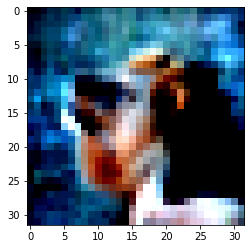

In [84]:
print(id2label[wrong_labels[idx].numpy().tolist()])
print(id2label[predictions[idx]])
image = wrong_images[idx].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(image)

# Visualization of CSAM Input from Vision Backbone

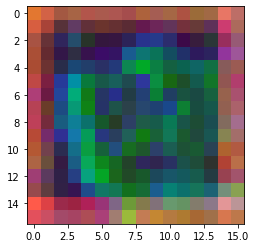

In [85]:
batch_norm = (batch_reduced - np.min(batch_reduced)) / (np.max(batch_reduced) - np.min(batch_reduced))
plt.imshow(batch_norm) 

# Visualization of Generated CSAM Filter

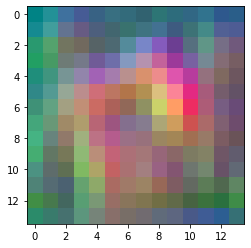

In [86]:
forget_norm = (forget_reduced - np.min(forget_reduced)) / (np.max(forget_reduced) - np.min(forget_reduced))
plt.imshow(forget_norm)

# Visualization of CSAM Output

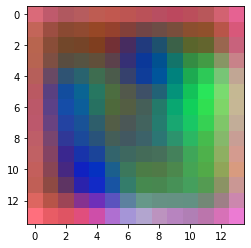

In [87]:
csam_norm = (csam_reduced - np.min(csam_reduced)) / (np.max(csam_reduced) - np.min(csam_reduced))
plt.imshow(csam_norm)

# Visualization of CSAM Filter Mean Cosine Similarities Along Each Location

<AxesSubplot:>

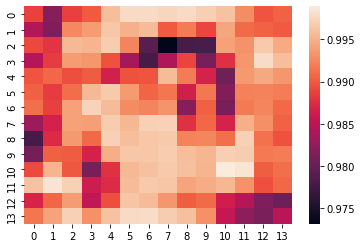

In [88]:
idx_filter_mean = F.normalize(forget_gate[idx].mean(0, keepdims=True), dim=-1)
mean_dissimilarity = (F.normalize(forget_gate[idx], dim=-1) * idx_filter_mean).sum(-1).reshape(14, 14)
sns.heatmap(mean_dissimilarity.detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


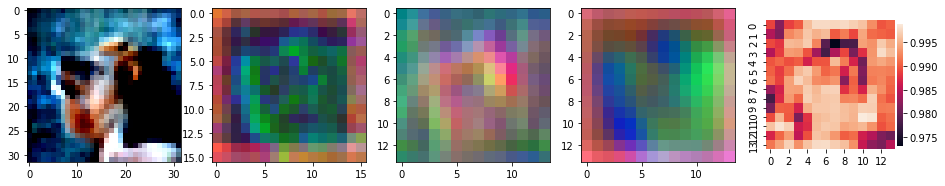

In [89]:
f, axarr = plt.subplots(1,5, figsize=(16,9))
axarr[0].imshow(image)
axarr[1].imshow(batch_norm)
axarr[2].imshow(forget_norm)
axarr[3].imshow(csam_norm)
sns.heatmap(mean_dissimilarity.detach().cpu().numpy(), ax=axarr[4],
           cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
           )
axarr[4].set_box_aspect(1)
# axarr[0, 4].imshow(image_datas[3])
f.show()

## Gives some indication of how similar/different each filter is from the others. I.e. what information it takes out from input.

<AxesSubplot:>

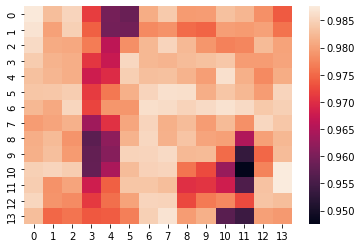

In [382]:
sns.heatmap(forget_cos[idx].mean(-1).reshape(14, 14).detach().cpu().numpy())

# Self Attention

In [4]:
cifar100_test_loader = get_test_dataloader(
    settings.CIFAR100_TRAIN_MEAN,
    settings.CIFAR100_TRAIN_STD,
    #settings.CIFAR100_PATH,
    num_workers=6,
    batch_size=1,
    shuffle=False
    )

Files already downloaded and verified


In [5]:
net = resnet18(
            variant_name='4', pos_emb_dim=10,
            softmax_temp=1, variant_loc=5,
            stochastic_stride=False, stride=1
        )

In [6]:
path = '/coc/pskynet4/gstoica3/checkpoints/resnet18/Tuesday_01_February_2022_00h_42m_26s/CSAM_Approach4_BN_PosEmb10_AfterConv5/resnet18-128-best.pth'
weights = torch.load(path)
net_params = {i[0]:i[1] for i in net.named_parameters()}
net.load_state_dict(weights)
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [7]:
net = net.cuda()

In [8]:
images = []
labels = []
desired_data = 64
for n_iter, (image, label) in tqdm(enumerate(cifar100_test_loader)):
    if n_iter >= desired_data: break
    image = image.cuda()
    images.append(image)
    labels.append(label)

64it [00:00, 402.32it/s]


In [9]:
images = torch.cat(images)
labels = torch.cat(labels)

In [66]:
predictions = net(images).argmax(-1).detach().cpu().numpy()

In [68]:
predictions == labels.numpy()

array([False,  True, False,  True,  True, False,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True, False,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [10]:
csam = net.network_layers[net.variant_loc]

In [18]:
output = images
for layer in tqdm(net.network_layers[:net.variant_loc]):
    output = layer(output)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.86it/s]


In [47]:
batch = csam.input_padder(output)                                                            # Pad batch for resolution reduction/preservation
batch = batch.permute(0, 2, 3, 1)                                                           # [B,C,H,W] -> [B,H,W,C]
batch_pos = csam.maybe_add_positional_encodings(batch)
X_l, X_g = csam.split_input(batch_pos, mask_X_g=False)

keys = csam.key_transform(X_g)                                                              # [1,B,HW,E]
queries = csam.query_transform(X_l)                                                         # [F,B,K^2,E]
values = csam.value_transform(X_g)                                                          # [1,B,HW,1]

raw_compatibilities = csam.cosine_similarity(
    keys, queries                                                                           # [1,B,HW,E], [F,B,K^2,E]
)                                                                                           # [F,B,HW,K^2]
compatabilities = F.softmax(
    csam.appraoch_args['softmax_temp'] * raw_compatibilities,
    dim=2
)
elem_mul = values * compatabilities                                                         # [1,B,HW,1] x [F,B,HW,K^2] -> [F,B,HW,K^2]
W_g = elem_mul.sum(dim=2).unsqueeze(-1)                                                     # [F,B,HW,K^2] -> [F,B,K^2] -> [F,B,K^2,1]
X_l = X_l[:, :, :, :csam.spatial_C]                                                         # [F,B,K^2,E] -> [F,B,K^2,C]
convolved_X = (W_g * X_l).sum(dim=2).permute(1,0,2)                                         # [F,B,K^2,1] x [F,B,K^2,C] -> [F,B,K^2,C] -> [F,B,C] -> [B,F,C]
convolved_X = convolved_X.reshape(
    -1, csam.convs_height, csam.convs_width, csam.spatial_C
)                                                                                           # [B,F,C] -> [B,F_H,F_W,C]


In [48]:
compatabilities = compatabilities.permute(1, 0, 3, 2)
compatabilities.shape

torch.Size([64, 4, 9, 16])

In [49]:
compat_cos = csam.cosine_similarity(compatabilities, compatabilities)
compat_cos.shape

torch.Size([64, 4, 9, 9])

In [54]:
compatabilities = compatabilities.detach().cpu().numpy()
compat_cos = compat_cos.detach().cpu().numpy()

<AxesSubplot:>

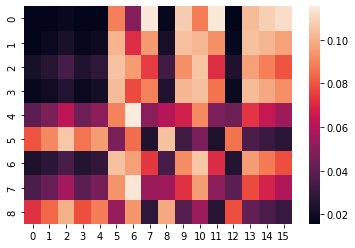

In [91]:
sns.heatmap(compatabilities[0, 0])

<AxesSubplot:>

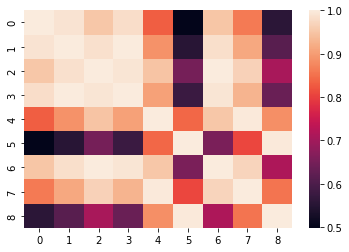

In [90]:
sns.heatmap(compat_cos[0, 0])

In [87]:
idx = 2
(predictions == labels.numpy())[idx]

False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


seal
otter


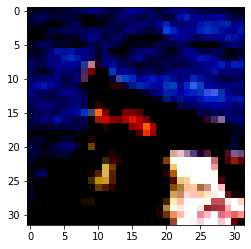

In [88]:
print(id2label[labels[idx].numpy().tolist()])
print(id2label[predictions[idx]])
image = images[idx].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


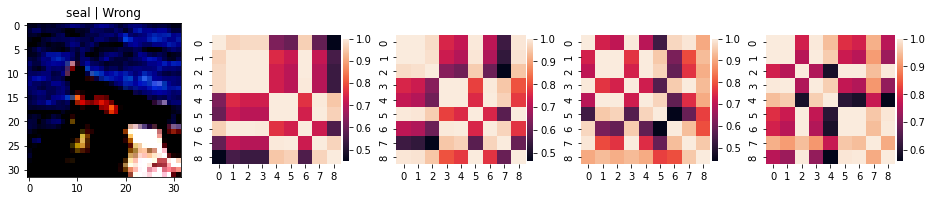

In [89]:
title = '{} | {}'.format(
    id2label[labels[idx].numpy().tolist()],
    'Correct' if (predictions == labels.numpy())[idx] else 'Wrong'
)
f, axarr = plt.subplots(1,5, figsize=(16,9))
axarr[0].imshow(images[idx].permute(1, 2, 0).detach().cpu().numpy())
axarr[0].set_title(title)
for i in range(1, 5):
    sns.heatmap(compat_cos[idx, i-1], ax=axarr[i],
           cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
           )
    axarr[i].set_box_aspect(1)
f.show()

In [ ]:
sa_pca = PCA(n_components=3)

sa_pca.fit(compatabilities[0, idx].reshape(-1, 128).detach().cpu().numpy())
print('Batch Explained Variance: {}'.format(batch_pca.explained_variance_ratio_))
print('Filter Explained Variance: {}'.format(filter_pca.explained_variance_ratio_))
print('CSAM Explained Variance: {}'.format(csam_pca.explained_variance_ratio_))

batch_reduced = batch_pca.transform(batch[idx].reshape(-1, 128).detach().cpu().numpy()).reshape(16, 16, 3)
csam_reduced = csam_pca.transform(convolved_X[idx].reshape(-1, 128).detach().cpu().numpy()).reshape(14, 14, 3)
forget_reduced = filter_pca.transform(forget_gate_np[idx]).reshape(14, 14, 3)

In [ ]:
idx_filter_mean = F.normalize(forget_gate[idx].mean(0, keepdims=True), dim=-1)
mean_dissimilarity = (F.normalize(forget_gate[idx], dim=-1) * idx_filter_mean).sum(-1).reshape(14, 14)
sns.heatmap(mean_dissimilarity.detach().cpu().numpy())